In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [2]:
import random
seed = random.randint(1, 1000)
print(seed)

290


In [3]:
img_size = 100 #original size of the image
targetx = 100
targety = 100

epochs = 30
batch_size = 16

In [4]:
train_dir = "D:\\Projects\\DIP Project (Emotion, Age, and Gender Detection\\rafdb\\DATASET\\train"
test_dir = "D:\\Projects\\DIP Project (Emotion, Age, and Gender Detection\\rafdb\\DATASET\\test"

In [5]:
"""
Data Augmentation
--------------------------
"""

train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.5
)

In [6]:
"""
Applying data augmentation to the images
"""
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,

)
val_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
     subset="training"

)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
    subset="validation",
        seed=seed
)

Found 12271 images belonging to 7 classes.
Found 1535 images belonging to 7 classes.
Found 1533 images belonging to 7 classes.


In [7]:
model = tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(targetx, targety, 3)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))  # Increased dropout

model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))  # Increased dropout

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Increased dropout

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Increased dropout

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 128)       5

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,  # Stop training if val_loss doesn't improve for 5 consecutive epochs
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  # Reduce learning rate by half
    patience=3,  # Wait for 3 epochs without improvement before reducing
    min_lr=1e-6  # Minimum learning rate
)

# Fit the model
history = model.fit(
    x=train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler]  # Add callbacks here
)


Epoch 1/30
767/767 [==============================] - 40s 41ms/step - loss: 10.6673 - accuracy: 0.2577 - val_loss: 11.2587 - val_accuracy: 0.2671
Epoch 2/30
767/767 [==============================] - 30s 39ms/step - loss: 9.5877 - accuracy: 0.3806 - val_loss: 9.3386 - val_accuracy: 0.4554
Epoch 3/30
767/767 [==============================] - 30s 39ms/step - loss: 8.5924 - accuracy: 0.4626 - val_loss: 8.2074 - val_accuracy: 0.5147
Epoch 4/30
767/767 [==============================] - 30s 39ms/step - loss: 7.6525 - accuracy: 0.4978 - val_loss: 6.9764 - val_accuracy: 0.5844
Epoch 5/30
767/767 [==============================] - 30s 39ms/step - loss: 6.7039 - accuracy: 0.5411 - val_loss: 6.1877 - val_accuracy: 0.5831
Epoch 6/30
767/767 [==============================] - 30s 39ms/step - loss: 5.8246 - accuracy: 0.5796 - val_loss: 5.5088 - val_accuracy: 0.6026
Epoch 7/30
767/767 [==============================] - 30s 39ms/step - loss: 5.0390 - accuracy: 0.6079 - val_loss: 4.4648 - val_accurac

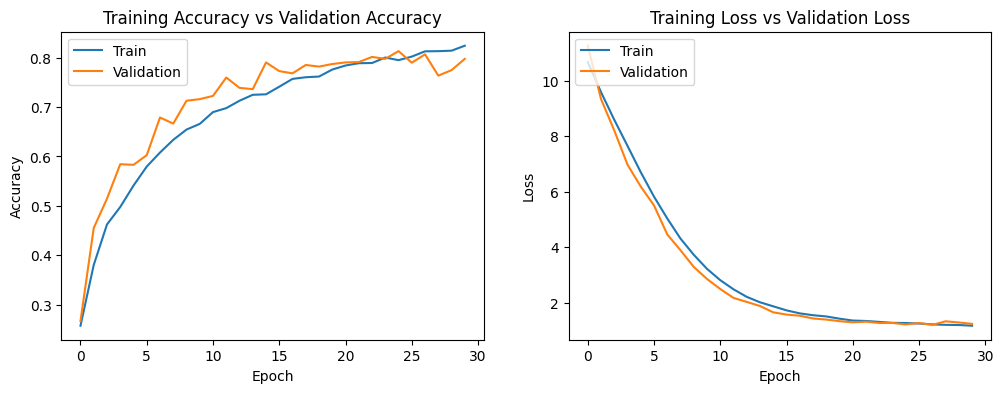

In [9]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [11]:
model.save('model_emotion.keras')

(100, 100, 3)


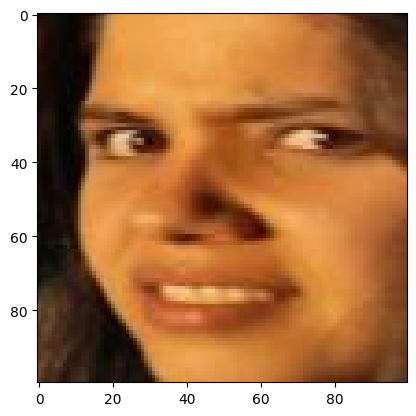

In [172]:
from keras.preprocessing import image
img = image.load_img(r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\rafdb\DATASET\test\3\test_1389_aligned.jpg",target_size = (targetx,targety,3))
img = np.array(img)
plt.imshow(img)
print(img.shape) #prints (48,48) that is the shape of our image

In [174]:
label_dict = {0: 'Surprise', 1: 'Fear', 2: 'Disgust', 3: 'Happy', 4: 'Sad', 5: 'Angry', 6: 'Neutral'}

img = np.expand_dims(img, axis=0) 
img = img.reshape(1, targetx, targety, 3)
result = model.predict(img)
result = list(result[0])
img_index = np.argmax(result)
print('Result:', result)
print('Predicted Emotion:', label_dict[img_index])


Result: [0.0, 0.0, 1.0, 0.0, 0.0, 4.1467595e-26, 0.0]
Predicted Emotion: Disgust


In [175]:
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc   = model.evaluate(val_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, val_acc*100))

96/96 [==============================] - 1s 11ms/step - loss: 1.2454 - accuracy: 0.7974
final train accuracy = 90.63 , validation accuracy = 79.74


In [176]:
test_loss, test_acc   = model.evaluate(test_generator)
print("final test accuracy = {:.2f}".format(test_acc*100))

96/96 [==============================] - 1s 11ms/step - loss: 1.1954 - accuracy: 0.8232
final test accuracy = 82.32


In [18]:
model.save_weights('model_emotion_weights.weights.h5')

(100, 100, 3)


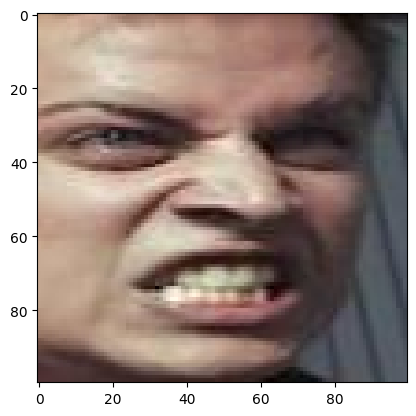

In [244]:
from keras.preprocessing import image
img = image.load_img(r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\rafdb\DATASET\test\6\test_1868_aligned.jpg",target_size = (targetx,targety,1))
img = np.array(img)
plt.imshow(img)
print(img.shape)

In [245]:
label_dict = {0: 'Surprise', 1: 'Fear', 2: 'Disgust', 3: 'Happy', 4: 'Sad', 5: 'Angry', 6: 'Neutral'}

img = np.expand_dims(img, axis=0) 
img = img.reshape(1, targetx, targety, 3)
result = model.predict(img)
result = list(result[0])
img_index = np.argmax(result)
print('Result:', result)
print('Predicted Emotion:', label_dict[img_index])

Result: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Predicted Emotion: Angry


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [2]:
path = Path(r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\Age and Gender Dataset\UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [3]:
print(len(filenames))
print(filenames[:3])

23708
['100_0_0_20170112213500903.jpg.chip.jpg', '100_0_0_20170112215240346.jpg.chip.jpg', '100_1_0_20170110183726390.jpg.chip.jpg']


In [4]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [5]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

In [6]:
df.head()

image age gender
0  23_1_2_20170116172910708.jpg.chip.jpg  23      1
1  28_0_1_20170113150719161.jpg.chip.jpg  28      0
2  26_1_0_20170116234741431.jpg.chip.jpg  26      1
3  37_0_3_20170119202516470.jpg.chip.jpg  37      0
4  60_0_0_20170109013457906.jpg.chip.jpg  60      0

In [7]:
# Initialize a male counter variable
male_count = 0

# Initialize variable to store all the ages.
ages = []
gender_mapping = ["Male", "Female"]

# Loop over the paths and check for male images.
for path in image_path:
    path_split = path.split("_")
    if "0" == path_split[1]:
        male_count += 1
    ages.append(int(path_split[0]))

# Computee total female counts
female_count = len(image_path) - male_count

# Visualizing The Class Imbalance
pie_chart = px.pie(
    names = gender_mapping,
    values = [male_count, female_count],
    hole = 0.4,
    title = "Gender Distribution (Donut Chart)",
    height = 500
)
pie_chart.show()

bar_graph = px.bar(
    y = gender_mapping,
    x = [male_count, female_count],
    title = "Gender Distribution (Bar Graph)",
    color = gender_mapping,
    height = 500
)
bar_graph.update_layout(
    yaxis_title = "Gender",
    xaxis_title = "Frequency Count"
)
bar_graph.show()

In [8]:
# Histogram
fig = px.histogram(sorted(ages), title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Value Counts"
)
fig.show()

# Violin Plot
fig = px.violin(x = sorted(ages), title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Distribution"
)
fig.show()

# Box Plot
fig = px.box(x = sorted(ages), notched=True, title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
)
fig.show()

In [9]:
gender_dict = {0:"Male",1:"Female"}
df = df.astype({'age':'float32', 'gender': 'int32'})

In [10]:
print(df.dtypes)


image      object
age       float32
gender      int32
dtype: object


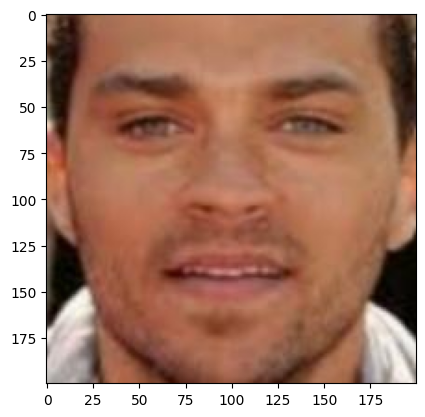

In [11]:
img = Image.open(r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\Age and Gender Dataset\UTKFace\\"+df.image[1])
plt.imshow(img)


C:\ProgramData\anaconda3\envs\gpu_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='age', ylabel='Density'>

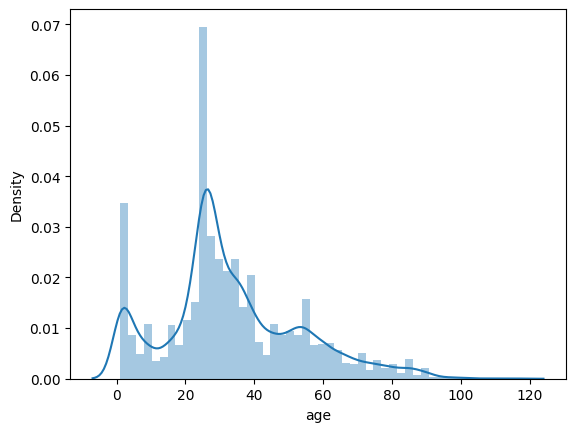

In [12]:
sns.distplot(df.age)

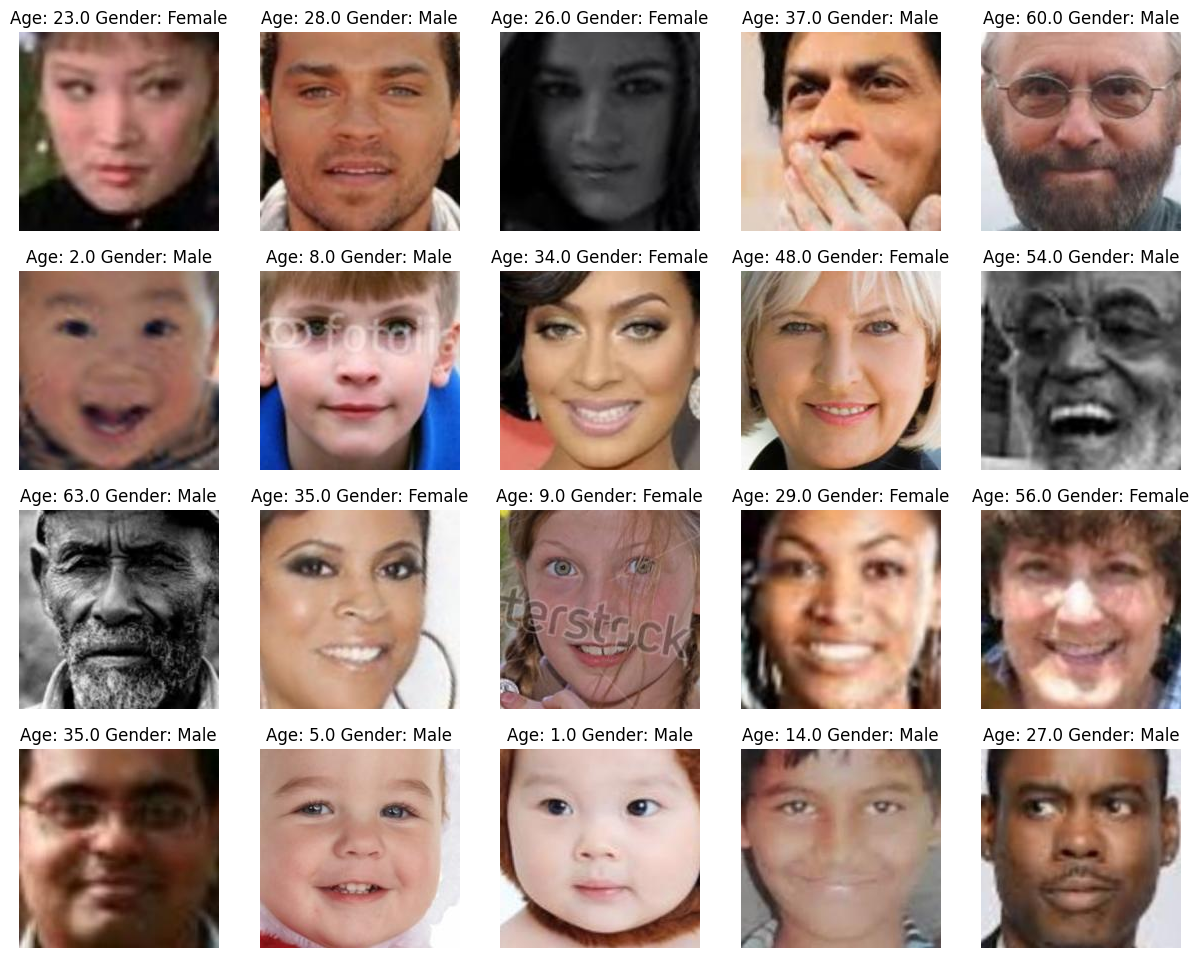

In [13]:
files = df.iloc[0:20]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img(r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\Age and Gender Dataset\UTKFace\\"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [14]:
train, test = train_test_split(df, test_size=0.85, random_state=42)

In [15]:
train.head()


image   age  gender
18199  78_1_1_20170113011857601.jpg.chip.jpg  78.0       1
19557  24_0_2_20170103223924087.jpg.chip.jpg  24.0       0
20132  34_1_3_20170119152405425.jpg.chip.jpg  34.0       1
11849  46_0_3_20170119183135878.jpg.chip.jpg  46.0       0
2100   30_0_2_20170116174814595.jpg.chip.jpg  30.0       0

In [16]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img(r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\Age and Gender Dataset\UTKFace\\"+file, color_mode='grayscale')
    img = img.resize((100,100), Image.Resampling.LANCZOS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 100,100,1)

In [17]:
x_train.shape


(3556, 100, 100, 1)

In [18]:
x_train = x_train/255


In [19]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [20]:
input_size = (100,100,1)


In [21]:
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 98, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 98, 98, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [22]:
model.compile(
    loss=['binary_crossentropy', 'mse'],  # Binary Crossentropy for gender, MAE (Mean Absolute Error) for age
    optimizer='adam',
    metrics=[['accuracy'], ['mae']]  # Accuracy for gender, MAE for age
)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 98, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 98, 98, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [24]:
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)

Epoch 1/20
320/320 [==============================] - 9s 11ms/step - loss: 420.9908 - gender_output_loss: 0.7447 - age_output_loss: 420.2463 - gender_output_accuracy: 0.6006 - age_output_mae: 15.7102 - val_loss: 826.7856 - val_gender_output_loss: 0.6691 - val_age_output_loss: 826.1166 - val_gender_output_accuracy: 0.6685 - val_age_output_mae: 23.2011
Epoch 2/20
320/320 [==============================] - 3s 10ms/step - loss: 264.4502 - gender_output_loss: 0.6225 - age_output_loss: 263.8277 - gender_output_accuracy: 0.6631 - age_output_mae: 12.3962 - val_loss: 216.4097 - val_gender_output_loss: 0.5968 - val_age_output_loss: 215.8128 - val_gender_output_accuracy: 0.6938 - val_age_output_mae: 11.1541
Epoch 3/20
320/320 [==============================] - 3s 10ms/step - loss: 213.0495 - gender_output_loss: 0.5413 - age_output_loss: 212.5081 - gender_output_accuracy: 0.7359 - age_output_mae: 10.9776 - val_loss: 207.9978 - val_gender_output_loss: 0.5239 - val_age_output_loss: 207.4740 - val_ge

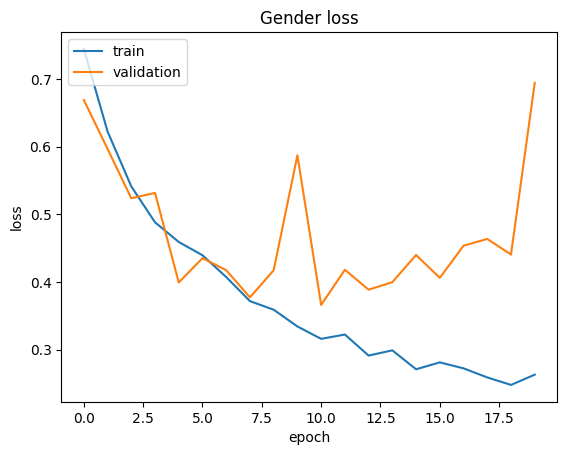

In [25]:
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

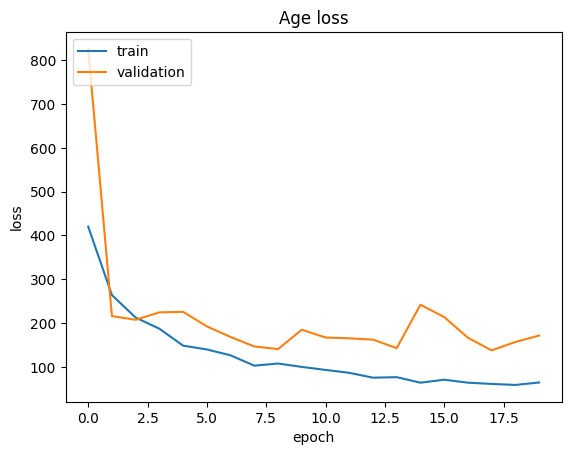

In [26]:
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Original: Gender =  Male  Age =  35.0
Prediction: Gender =  Male  Age =  47


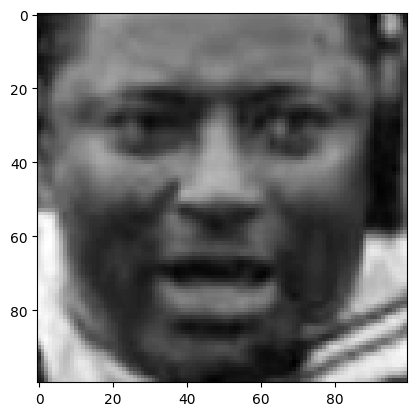

In [27]:
index=50
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 100, 100, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(100,100), cmap='gray')

Original: Gender =  Female  Age =  35.0
Prediction: Gender =  Female  Age =  39


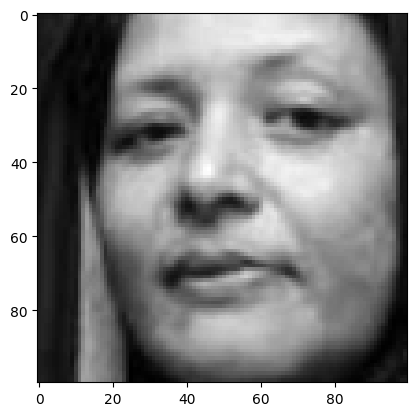

In [28]:
index=20
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 100, 100, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(100,100), cmap='gray')

In [29]:
# Save the model in .h5 format
model.save('age_gender.h5')

In [30]:
model.save('age_gender.keras')

In [31]:
# Load pre-trained models
emotion_model = load_model(r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\model_emotion.keras")  # Replace with actual model file path
age_gender_model = load_model(r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\age_gender.keras")  # Replace with actual model file path


Raw gender prediction output: [0.07311883]
Raw age prediction output: [43.63151]
Predicted Emotion: Happy
Predicted Age: 44
Predicted Gender: Male


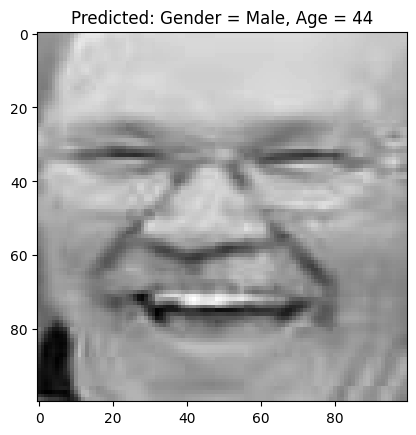

In [32]:
import numpy as np
import cv2
from keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import preprocess_input

# Load the models
emotion_model = load_model(r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\model_emotion.keras")  # Replace with actual model file path
age_gender_model = load_model(r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\age_gender.keras")

# Dictionary for emotion and gender labels
label_dict = {0: 'Surprise', 1: 'Fear', 2: 'Disgust', 3: 'Happy', 4: 'Sad', 5: 'Angry', 6: 'Neutral'}
gender_dict = {0: 'Female', 1: 'Male'}

# Preprocess image for emotion model
def preprocess_image_for_emotion(image_path, target_size=(100, 100)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)  # Resize to the target size of the emotion model
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)  # Normalize the image
    return img

# Preprocess image for age/gender model
def preprocess_image_for_age_gender(image_path, target_size=(100, 100)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.resize(img, target_size)  # Resize to the target size of the age/gender model
    img = np.expand_dims(img, axis=-1)  # Add the channel dimension for grayscale (1 channel)
    img = np.expand_dims(img, axis=0)   # Add the batch dimension
    img = img.astype('float32') / 255.0  # Normalize the image to [0, 1]
    return img

# Make predictions
def predict_emotion(image):
    emotion_prediction = emotion_model.predict(image)
    emotion_label = np.argmax(emotion_prediction)  # Get the index of the highest predicted probability
    return label_dict[emotion_label]  # Return the corresponding label

def predict_age_gender(image):
    age_gender_prediction = age_gender_model.predict(image)
    
    # Debugging: Print the raw output of the model
    print(f"Raw gender prediction output: {age_gender_prediction[0][0]}")
    print(f"Raw age prediction output: {age_gender_prediction[1][0]}")

    # Gender is predicted from the first part of the output
    # If prediction > 0.5, assume Male; else, assume Female
    if age_gender_prediction[0][0][0] < 0.5:
        pred_gender = 'Male'
    else:
        pred_gender = 'Female'
    
    # Age is predicted from the second part of the output
    pred_age = round(age_gender_prediction[1][0][0])
    
    return pred_age, pred_gender

# Input image path
image_path = r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\rafdb\DATASET\test\4\test_0033_aligned.jpg"

# Preprocess the image for both models
emotion_image = preprocess_image_for_emotion(image_path)
age_gender_image = preprocess_image_for_age_gender(image_path)

# Get predictions from both models
emotion = predict_emotion(emotion_image)
age, gender = predict_age_gender(age_gender_image)

# Output the results
print(f"Predicted Emotion: {emotion}")
print(f"Predicted Age: {age}")
print(f"Predicted Gender: {gender}")

# Display the image (assuming grayscale for age/gender model)
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(cv2.resize(img, (100, 100)), cmap='gray')
plt.title(f"Predicted: Gender = {gender}, Age = {age}")
plt.show()


Raw gender prediction output: [0.08932021]
Raw age prediction output: [45.054882]
Predicted Emotion: Sad
Predicted Age: 45
Predicted Gender: Male


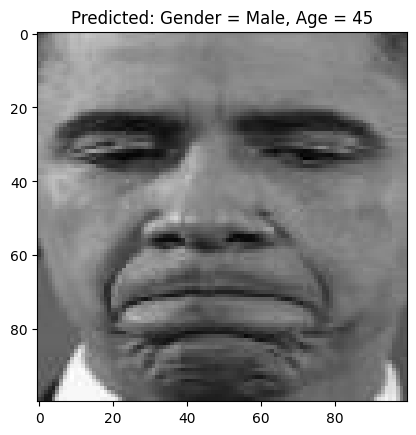

In [33]:
import numpy as np
import cv2
from keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import preprocess_input

# Load the models
emotion_model = load_model(r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\model_emotion.keras")  # Replace with actual model file path
age_gender_model = load_model(r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\age_gender.keras")

# Dictionary for emotion and gender labels
label_dict = {0: 'Surprise', 1: 'Fear', 2: 'Disgust', 3: 'Happy', 4: 'Sad', 5: 'Angry', 6: 'Neutral'}
gender_dict = {0: 'Female', 1: 'Male'}

# Preprocess image for emotion model
def preprocess_image_for_emotion(image_path, target_size=(100, 100)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)  # Resize to the target size of the emotion model
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)  # Normalize the image
    return img

# Preprocess image for age/gender model
def preprocess_image_for_age_gender(image_path, target_size=(100, 100)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.resize(img, target_size)  # Resize to the target size of the age/gender model
    img = np.expand_dims(img, axis=-1)  # Add the channel dimension for grayscale (1 channel)
    img = np.expand_dims(img, axis=0)   # Add the batch dimension
    img = img.astype('float32') / 255.0  # Normalize the image to [0, 1]
    return img

# Make predictions
def predict_emotion(image):
    emotion_prediction = emotion_model.predict(image)
    emotion_label = np.argmax(emotion_prediction)  # Get the index of the highest predicted probability
    return label_dict[emotion_label]  # Return the corresponding label

def predict_age_gender(image):
    age_gender_prediction = age_gender_model.predict(image)
    
    # Debugging: Print the raw output of the model
    print(f"Raw gender prediction output: {age_gender_prediction[0][0]}")
    print(f"Raw age prediction output: {age_gender_prediction[1][0]}")

    # Gender is predicted from the first part of the output
    # If prediction > 0.5, assume Male; else, assume Female
    if age_gender_prediction[0][0][0] < 0.5:
        pred_gender = 'Male'
    else:
        pred_gender = 'Female'
    
    # Age is predicted from the second part of the output
    pred_age = round(age_gender_prediction[1][0][0])
    
    return pred_age, pred_gender

# Input image path
image_path = r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\rafdb\DATASET\test\5\test_1606_aligned.jpg"
# Preprocess the image for both models
emotion_image = preprocess_image_for_emotion(image_path)
age_gender_image = preprocess_image_for_age_gender(image_path)

# Get predictions from both models
emotion = predict_emotion(emotion_image)
age, gender = predict_age_gender(age_gender_image)

# Output the results
print(f"Predicted Emotion: {emotion}")
print(f"Predicted Age: {age}")
print(f"Predicted Gender: {gender}")

# Display the image (assuming grayscale for age/gender model)
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(cv2.resize(img, (100, 100)), cmap='gray')
plt.title(f"Predicted: Gender = {gender}, Age = {age}")
plt.show()


Raw gender prediction output: [0.9895794]
Raw age prediction output: [36.071068]
Predicted Emotion: Sad
Predicted Age: 36
Predicted Gender: Female


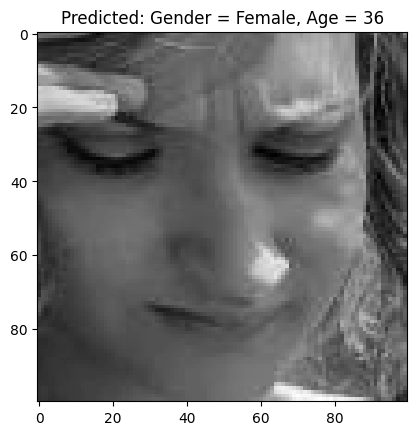

In [34]:
import numpy as np
import cv2
from keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import preprocess_input
# Load the models
emotion_model = load_model(r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\model_emotion.keras")  # Replace with actual model file path
age_gender_model = load_model(r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\age_gender.keras")

# Dictionary for emotion and gender labels
label_dict = {0: 'Surprise', 1: 'Fear', 2: 'Disgust', 3: 'Happy', 4: 'Sad', 5: 'Angry', 6: 'Neutral'}
gender_dict = {0: 'Female', 1: 'Male'}

# Preprocess image for emotion model
def preprocess_image_for_emotion(image_path, target_size=(100, 100)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)  # Resize to the target size of the emotion model
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)  # Normalize the image
    return img

# Preprocess image for age/gender model
def preprocess_image_for_age_gender(image_path, target_size=(100, 100)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.resize(img, target_size)  # Resize to the target size of the age/gender model
    img = np.expand_dims(img, axis=-1)  # Add the channel dimension for grayscale (1 channel)
    img = np.expand_dims(img, axis=0)   # Add the batch dimension
    img = img.astype('float32') / 255.0  # Normalize the image to [0, 1]
    return img

# Make predictions
def predict_emotion(image):
    emotion_prediction = emotion_model.predict(image)
    emotion_label = np.argmax(emotion_prediction)  # Get the index of the highest predicted probability
    return label_dict[emotion_label]  # Return the corresponding label

def predict_age_gender(image):
    age_gender_prediction = age_gender_model.predict(image)
    
    # Debugging: Print the raw output of the model
    print(f"Raw gender prediction output: {age_gender_prediction[0][0]}")
    print(f"Raw age prediction output: {age_gender_prediction[1][0]}")

    # Gender is predicted from the first part of the output
    # If prediction > 0.5, assume Male; else, assume Female
    if age_gender_prediction[0][0][0] < 0.5:
        pred_gender = 'Male'
    else:
        pred_gender = 'Female'
    
    # Age is predicted from the second part of the output
    pred_age = round(age_gender_prediction[1][0][0])
    
    return pred_age, pred_gender

# Input image path
image_path = r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\rafdb\DATASET\test\5\test_0030_aligned.jpg"
# Preprocess the image for both models
emotion_image = preprocess_image_for_emotion(image_path)
age_gender_image = preprocess_image_for_age_gender(image_path)

# Get predictions from both models
emotion = predict_emotion(emotion_image)
age, gender = predict_age_gender(age_gender_image)

# Output the results
print(f"Predicted Emotion: {emotion}")
print(f"Predicted Age: {age}")
print(f"Predicted Gender: {gender}")

# Display the image (assuming grayscale for age/gender model)
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(cv2.resize(img, (100, 100)), cmap='gray')
plt.title(f"Predicted: Gender = {gender}, Age = {age}")
plt.show()


In [47]:
mood_music = pd.read_csv("D:\Projects\DIP Project (Emotion, Age, and Gender Detection\data_moods_for_songs_Dataset.csv")
mood_music = mood_music[['name','artist','mood', 'popularity']]
mood_music.head()

name          artist       mood  \
0                                         1999          Prince      Happy   
1                                           23  Blonde Redhead        Sad   
2                                     9 Crimes     Damien Rice        Sad   
3                               99 Luftballons            Nena      Happy   
4  A Boy Brushed Red Living In Black And White       Underoath  Energetic   

   popularity  
0          68  
1          43  
2          60  
3           2  
4          60

In [49]:
mood_music["mood"].value_counts()

Sad          197
Calm         195
Energetic    154
Happy        140
Name: mood, dtype: int64

In [70]:
if(result[0]==0 or result[0]==1 or result[0]==2 ):
    #for angery,disgust,fear
    filter1=mood_music['mood']=='Calm'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==3 or result[0]==4):
    #for happy, neutral
    filter1=mood_music['mood']=='Happy'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==5):
       #for Sad
    filter1=mood_music['mood']=='Sad'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==6):
     #for surprise
    filter1=mood_music['mood']=='Energetic'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)

NameError: name 'result' is not defined

Raw gender prediction output: [0.0225744]
Raw age prediction output: [33.89522]
Predicted Emotion: ('Happy', array([7.1723136e-08, 2.1015947e-05, 5.7376190e-05, 9.8883456e-01,
       1.1077939e-02, 3.8856656e-06, 5.0522763e-06], dtype=float32))
Predicted Age: 34
Predicted Gender: Male


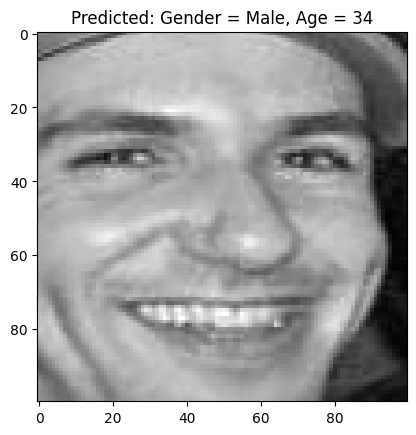

NameError: name 'emotion_prediction' is not defined

In [73]:
import numpy as np
import cv2
from keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import preprocess_input
# Load the models
emotion_model = load_model(r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\model_emotion.keras")  # Replace with actual model file path
age_gender_model = load_model(r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\age_gender.keras")

# Dictionary for emotion and gender labels
label_dict = {0: 'Surprise', 1: 'Fear', 2: 'Disgust', 3: 'Happy', 4: 'Sad', 5: 'Angry', 6: 'Neutral'}
gender_dict = {0: 'Female', 1: 'Male'}

# Preprocess image for emotion model
def preprocess_image_for_emotion(image_path, target_size=(100, 100)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)  # Resize to the target size of the emotion model
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)  # Normalize the image
    return img

# Preprocess image for age/gender model
def preprocess_image_for_age_gender(image_path, target_size=(100, 100)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.resize(img, target_size)  # Resize to the target size of the age/gender model
    img = np.expand_dims(img, axis=-1)  # Add the channel dimension for grayscale (1 channel)
    img = np.expand_dims(img, axis=0)   # Add the batch dimension
    img = img.astype('float32') / 255.0  # Normalize the image to [0, 1]
    return img

# Make predictions
def predict_emotion(image):
    emotion_prediction = emotion_model.predict(image)
    emotion_label = np.argmax(emotion_prediction)  # Get the index of the highest predicted probability
    return label_dict[emotion_label] # Return the corresponding label

def predict_age_gender(image):
    age_gender_prediction = age_gender_model.predict(image)
    
    # Debugging: Print the raw output of the model
    print(f"Raw gender prediction output: {age_gender_prediction[0][0]}")
    print(f"Raw age prediction output: {age_gender_prediction[1][0]}")

    # Gender is predicted from the first part of the output
    # If prediction > 0.5, assume Male; else, assume Female
    if age_gender_prediction[0][0][0] < 0.5:
        pred_gender = 'Male'
    else:
        pred_gender = 'Female'
    
    # Age is predicted from the second part of the output
    pred_age = round(age_gender_prediction[1][0][0])
    
    return pred_age, pred_gender

# Input image path
image_path = r"D:\Projects\DIP Project (Emotion, Age, and Gender Detection\rafdb\DATASET\test\4\test_0752_aligned.jpg"
emotion_image = preprocess_image_for_emotion(image_path)
age_gender_image = preprocess_image_for_age_gender(image_path)

# Get predictions from both models
emotion = predict_emotion(emotion_image)
age, gender = predict_age_gender(age_gender_image)

# Output the results
print(f"Predicted Emotion: {emotion}")
print(f"Predicted Age: {age}")
print(f"Predicted Gender: {gender}")

# Display the image (assuming grayscale for age/gender model)
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(cv2.resize(img, (100, 100)), cmap='gray')
plt.title(f"Predicted: Gender = {gender}, Age = {age}")
plt.show()


if(emotion=='Angry' or emotion=='Disgust' or emotion=='Fear' ):
    #for angery,disgust,fear
    filter1=mood_music['mood']=='Calm'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(emotion=='Happy' or emotion=='Neutral'):
    #for happy, neutral
    filter1=mood_music['mood']=='Happy'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(emotion=='Sad'):
       #for Sad
    filter1=mood_music['mood']=='Sad'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(emotion_prediction[0]==6):
     #for surprise
    filter1=mood_music['mood']=='Energetic'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)